# NEURAL STYLE TRANSFER
Turning picuture into cartoons

### Loading dependencies

In [6]:
import os
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False
import numpy as np
import PIL.Image
import time
import functools
from pathlib import Path

### Function tensor to image

In [7]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

### Function to load a image

In [8]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

### Image paths

In [9]:
content_path = 'Bilder/Foto_klein_Yves_face.jpg'
style_path = 'Bilder/boy-face.jpg'

# Looking at the images

In [10]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

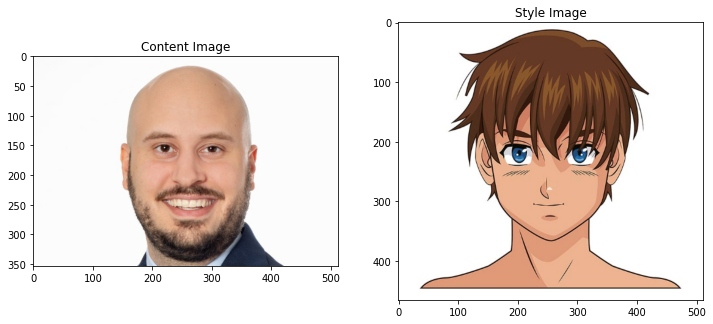

In [12]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')
plt.savefig('content_style_image.png')

# Building the model and training steps

In [8]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [9]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('suit', 0.29044074),
 ('Windsor_tie', 0.15285918),
 ('bow_tie', 0.12728988),
 ('lab_coat', 0.044237323),
 ('academic_gown', 0.032955267)]

In [10]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [11]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [12]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [13]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 466, 511, 64)
  min:  0.0
  max:  876.13245
  mean:  34.86434

block2_conv1
  shape:  (1, 233, 255, 128)
  min:  0.0
  max:  4649.2065
  mean:  193.34978

block3_conv1
  shape:  (1, 116, 127, 256)
  min:  0.0
  max:  10521.098
  mean:  183.59067

block4_conv1
  shape:  (1, 58, 63, 512)
  min:  0.0
  max:  20927.705
  mean:  638.0131

block5_conv1
  shape:  (1, 29, 31, 512)
  min:  0.0
  max:  5233.6567
  mean:  45.683445



In [14]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [15]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [16]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  144251.12
    mean:  424.36377

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  233716.34
    mean:  11505.138

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  334335.97
    mean:  9146.805

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4107175.0
    mean:  134422.89

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  252159.77
    mean:  1248.6279

Contents:
   block5_conv2
    shape:  (1, 22, 32, 512)
    min:  0.0
    max:  1347.3507
    mean:  11.470268


In [37]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
image = tf.Variable(content_image)

In [18]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [19]:
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

    return x_var, y_var

In [20]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [21]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [22]:
total_variation_loss(image).numpy()


9874.584

In [23]:
image = tf.Variable(content_image)
total_variation_weight=50
opt = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.50, epsilon=1e-1)
style_weight=1e-4
content_weight=1e1

In [24]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

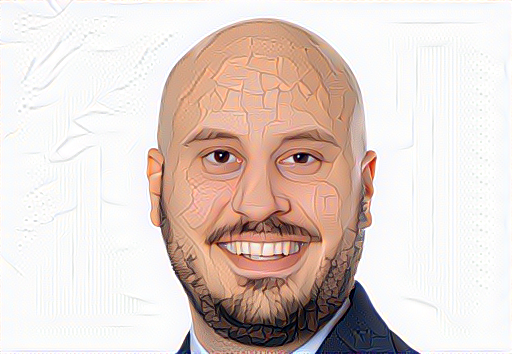

In [24]:
for i in range(0,10):
    train_step(image)
tensor_to_image(image)

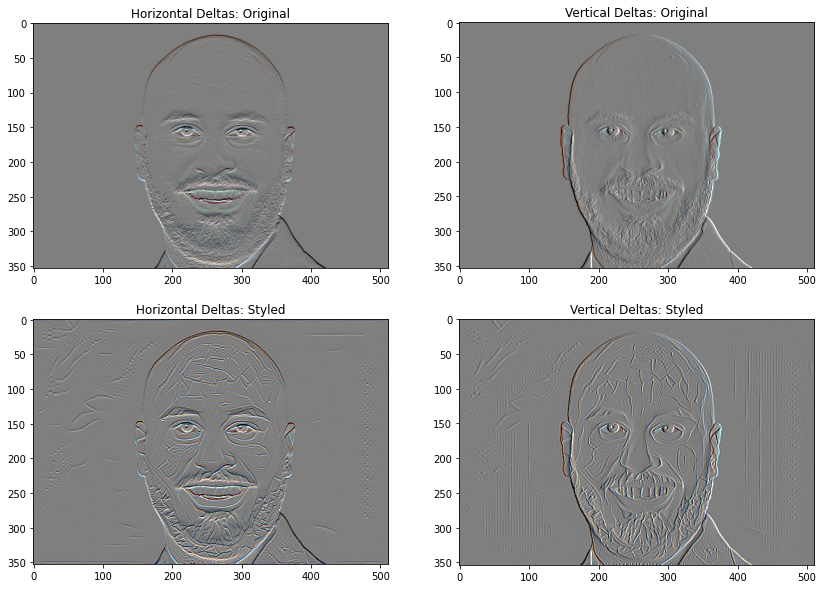

In [25]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

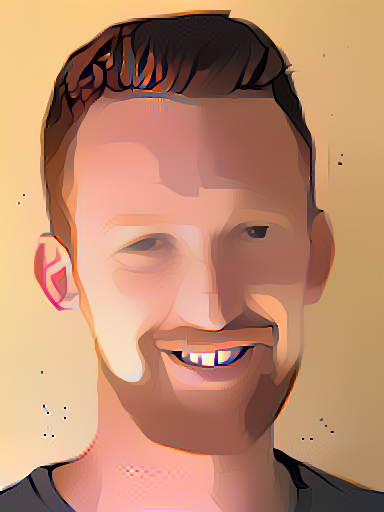

Train step: 1500 9520.595
Total time: 47.9


In [40]:
content_path = 'Bilder/Foto_klein_Yves_face.jpg'
style_path = 'Bilder/boy-face.jpg'


name = 'yves'
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
image = tf.Variable(content_image)
total_variation_weight=50
opt = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.50, epsilon=1e-1)
style_weight=1e-4
content_weight=1e1

start = time.time()

epochs = 15
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step), total_variation_loss(image).numpy())

end = time.time()
print("Total time: {:.1f}".format(end-start))
save_dir = 'NST_Output_Final'
Path(save_dir).mkdir(exist_ok=True)
file_name = save_dir + '/stylized-image_{}.png'.format(name)
tensor_to_image(image).save(file_name)

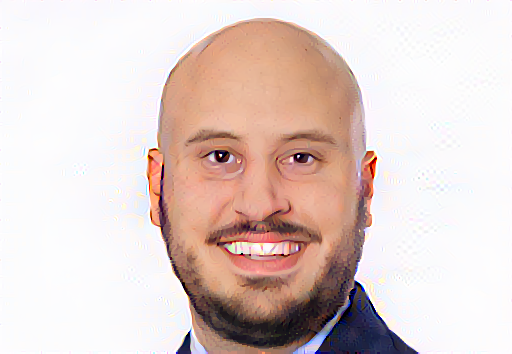

Train step: 1500
Total time: 62.7


In [44]:
# training different parameters
image = tf.Variable(content_image)
total_variation_weights=[2,50]
learning_rates = [0.02, 0.001]
beta_1s = [0.99, 0.5]
epsilons = [0.1, 0.0005]
style_weights= [0.1, 0.0001]
content_weights= [10, 10000]


for tvw in total_variation_weights:
    print(tvw)
    for lr in learning_rates:
        print(lr)
        for b1 in beta_1s:
            print(b1)
            for ep in epsilons:
                print(ep)
                for sw in style_weights:
                    print(sw)
                    for cw in content_weights:
                        print(cw)
                        @tf.function()
                        def train_step(image):
                            with tf.GradientTape() as tape:
                                outputs = extractor(image)
                                loss = style_content_loss(outputs)
                                loss += total_variation_weight*tf.image.total_variation(image)

                            grad = tape.gradient(loss, image)
                            opt.apply_gradients([(grad, image)])
                            image.assign(clip_0_1(image))
                        image = tf.Variable(content_image)
                        style_targets = extractor(style_image)['style']
                        content_targets = extractor(content_image)['content']
                        total_variation_weight=tvw
                        opt = tf.optimizers.Adam(learning_rate=lr, beta_1=b1, epsilon=ep)
                        style_weight=sw
                        content_weight=cw
                        
                        start = time.time()
                        
                        epochs = 15
                        steps_per_epoch = 100
                        step = 0
                        for n in range(epochs):
                            for m in range(steps_per_epoch):
                                step += 1
                                train_step(image)
                                print(".", end='', flush=True)
                            display.clear_output(wait=True)
                            display.display(tensor_to_image(image))
                            print("Train step: {}".format(step))

                        end = time.time()
                        print("Total time: {:.1f}".format(end-start))
                        save_dir = 'NST_Output_15'
                        Path(save_dir).mkdir(exist_ok=True)
                        file_name = save_dir + '/stylized-image_{}_{}_{}_{}_{}_{}.png'.format(tvw, lr, b1, ep, sw, cw)
                        tensor_to_image(image).save(file_name)